# What is Parkinson Disease
Parkinson’s disease is a nervous system disorder that affects movement. If you have seen the movie Love & other drugs then you know something about it. There are various stages in Parkinson Disease. <br>
Stage 1: Mild symptoms that do not typically interfere with daily life, including tremors and movement issues on only one side of the body.<br>
Stage 2: Symptoms continue to become worse with both tremors and rigidity now affecting both sides of the body. Daily tasks become challenging.<br>
Stage 3: Loss of balance and movements with falls becoming frequent and common. The patient is still capable of (typically) living independently.<br>
Stage 4: Symptoms become severe and constraining. The patient is unable to live alone and requires help to perform daily activities.<br>
Stage 5: Likely impossible to walk or stand. The patient is most likely wheelchair bound and may even experience hallucinations.<br>

Detection Parkinson Disease involves analysing the Spiral and Wave pattern drawn by the patients. <br>

Spiral: 102 images, 72 training, and 30 testing<br>
Wave: 102 images, 72 training, and 30 testing

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [84]:
wave = "dataset/wave/"
spiral = "dataset/spiral/"
val = [wave, spiral] # 0 for wave 1 for spiral
index = 0

In [76]:
# Let’s define a function to quantify a wave/spiral image  with the HOG method:
def quantify_image(image):
    # compute the histogram of oriented gradients feature vector for
    # the input image
    features = feature.hog(image, orientations=9,
        pixels_per_cell=(10, 10), cells_per_block=(2, 2),
        transform_sqrt=True, block_norm="L1")

    # return the feature vector
    return features

In [77]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []

    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]

        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))

        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        # quantify the image
        features = quantify_image(image)

        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)

    # return the data and labels
    return (np.array(data), np.array(labels))

In [82]:
def define_split_train(path):
    # define the path to the training and testing directories
    trainingPath = os.path.sep.join([path, "training"])
    testingPath = os.path.sep.join([path, "testing"])

    # loading the training and testing data
    print("[INFO] loading data...")
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)

    # encode the labels as integers
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)
    # initialize our trials dictionary
    trials = {}
    for i in range(0, 5):
        # train the model
        print("[INFO] training model {} of {}...".format(i + 1,
            5))
        model = RandomForestClassifier(n_estimators=100)
        model.fit(trainX, trainY)

        # make predictions on the testing data and initialize a dictionary
        # to store our computed metrics
        predictions = model.predict(testX)
        metrics = {}

        # compute the confusion matrix and and use it to derive the raw
        # accuracy, sensitivity, and specificity
        cm = confusion_matrix(testY, predictions).flatten()
        (tn, fp, fn, tp) = cm
        metrics["acc"] = (tp + tn) / float(cm.sum())
        metrics["sensitivity"] = tp / float(tp + fn)
        metrics["specificity"] = tn / float(tn + fp)

        # loop over the metrics
        for (k, v) in metrics.items():
            # update the trials dictionary with the list of values for
            # the current metric
            l = trials.get(k, [])
            l.append(v)
            trials[k] = l
        # loop over our metrics
    for metric in ("acc", "sensitivity", "specificity"):
        # grab the list of values for the current metric, then compute
        # the mean and standard deviation
        values = trials[metric]
        mean = np.mean(values)
        std = np.std(values)

        # show the computed metrics for the statistic
        print(metric)
        print(metrics["acc"])
        print("=" * len(metric))
        print("u={:.4f}, o={:.4f}".format(mean, std))
        print("")
        
        testingPaths = list(paths.list_images(testingPath))
    idxs = np.arange(0, len(testingPaths))
    idxs = np.random.choice(idxs, size=(25,), replace=False)
    images = []

    # loop over the testing samples
    for i in idxs:
        # load the testing image, clone it, and resize it
        image = cv2.imread(testingPaths[i])
        output = image.copy()
        output = cv2.resize(output, (128, 128))

        # pre-process the image in the same manner we did earlier
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
            cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image and make predictions based on the extracted
        # features using the last trained Random Forest
        features = quantify_image(image)
        preds = model.predict([features])
        label = le.inverse_transform(preds)[0]

        # draw the colored class label on the output image and add it to
        # the set of output images
        color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
            color, 2)
        images.append(output)

    # create a montage using 128x128 "tiles" with 5 rows and 5 columns
    montage = build_montages(images, (128, 128), (5, 5))[0]
    plt.imshow(montage, aspect='auto')
    # show the output montage
    # cv2.imshow("Output", montage)
    # cv2.waitKey(0)




[INFO] loading data...
[INFO] training model 1 of 5...
[INFO] training model 2 of 5...
[INFO] training model 3 of 5...
[INFO] training model 4 of 5...
[INFO] training model 5 of 5...
acc
0.8
===
u=0.8200, o=0.0267

sensitivity
0.8
u=0.7467, o=0.0499

specificity
0.8
u=0.8933, o=0.0327



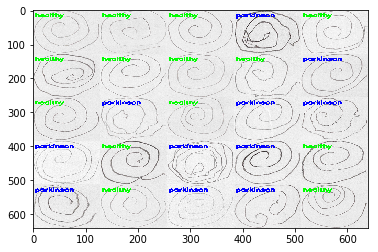

In [83]:
define_split_train(val[1])

In [15]:
# Now lets apply deep learning to it and see if reults improve

In [66]:
import numpy as np
import seaborn as sns
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
# from keras.backend import clear_session
from keras.optimizers import SGD, Adam
from pathlib import Path
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Conv2D, AveragePooling2D
from keras import initializers, regularizers
from pathlib import Path
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, History, LearningRateScheduler
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.image as mpimg

In [3]:
!pwd

/Users/lakshaychhabra/Desktop/Open Cv projects/Medical/Parkinson Disease


In [4]:
train_healthy = (len([iq for iq in os.scandir('dataset/spiral/training/healthy/')]))
train_parkinson = (len([iq for iq in os.scandir('dataset/spiral/training/parkinson/')]))
test_healthy = (len([iq for iq in os.scandir('dataset/spiral/testing/healthy/')]))
test_parkinson = (len([iq for iq in os.scandir('dataset/spiral/testing/parkinson/')]))

In [5]:
train_data = [train_healthy, train_parkinson]
test_data = [test_healthy, test_parkinson]

In [6]:
print("Total train data of healthy person is {} and patient is {} and total sum is {}".format(train_data[0], train_data[1], sum(train_data)))
print("Total test data of healthy person is {} and patient is {} and total sum is {}".format(test_data[0], test_data[1], sum(test_data)))


Total train data of healthy person is 36 and patient is 36 and total sum is 72
Total test data of healthy person is 15 and patient is 15 and total sum is 30


In [14]:
train_path = r"dataset/spiral/training"
test_path = r"dataset/spiral/testing"

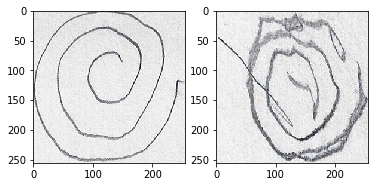

In [12]:
# Example of data of healthy person and parkinson patient : 
f, (ax1, ax2) = plt.subplots(1, 2)
img = mpimg.imread(train_path+"/healthy/V01HE03.png")
ax1.imshow(img)
img=mpimg.imread(train_path+"/parkinson/V04PE02.png") 
ax2.imshow(img)

In [63]:
train_data_generation = ImageDataGenerator(rescale=1./255, rotation_range=90, 
    width_shift_range=0.5, height_shift_range=0.5, shear_range=0.2, zoom_range=[0.9, 1.25], 
    channel_shift_range=20, horizontal_flip=True, vertical_flip = True, fill_mode='reflect'
)
validation_data_generation = ImageDataGenerator(rescale=1./255 )#need float values 

In [65]:
size = 224
train_generator = train_data_generation.flow_from_directory( train_path,
target_size=(size, size), class_mode='categorical', batch_size = 64, 
)
validation_generator = validation_data_generation.flow_from_directory( test_path,
target_size=(size, size), class_mode='categorical', batch_size = 64, 
)

Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [67]:
conv_m = MobileNetV2(weights='imagenet', include_top=False, input_shape=(size, size, 3))
conv_m.trainable = False
conv_m.summary()

9412608/9406464 [==============================] - 24s 3us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____________________________________________

In [68]:
model = Sequential()
model.add(conv_m)
model.add(AveragePooling2D(pool_size=(7, 7)))
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(BatchNormalization()) 
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_23 (Averag (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                81984     
_________________________________________________________________
batch_normalization_24 (Batc (None, 64)                256       
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 130       
Total para

In [69]:
checkpoint = ModelCheckpoint("weights{epoch:05d}.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, cooldown=0, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reduce]

model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr = 0.1, momentum = 0.9),
    metrics=['accuracy']
)

In [70]:
start = datetime.now()
history = model.fit_generator(
    train_generator,
    callbacks=callbacks,
    epochs=30,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=2
)

Epoch 1/30
10/10 [==============================] - 60s 6s/step - loss: 0.8748 - acc: 0.6614 - val_loss: 2.4142 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to weights00001.h5
Epoch 2/30
10/10 [==============================] - 52s 5s/step - loss: 1.0802 - acc: 0.6136 - val_loss: 0.6840 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.50000 to 0.60000, saving model to weights00002.h5
Epoch 3/30
10/10 [==============================] - 55s 6s/step - loss: 0.9907 - acc: 0.6517 - val_loss: 1.3308 - val_acc: 0.5000

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/30
10/10 [==============================] - 52s 5s/step - loss: 1.1147 - acc: 0.6168 - val_loss: 0.7931 - val_acc: 0.6000

Epoch 00004: val_acc did not improve from 0.60000
Epoch 5/30
10/10 [==============================] - 53s 5s/step - loss: 0.6867 - acc: 0.7749 - val_loss: 1.0617 - val_acc: 0.5000

Epoch 00005: val_acc did not improve from 0.60000
Epoch 6/30
10/10 [======

KeyboardInterrupt: 

In [72]:
print("So the maximum Accuracy on Test was 60%")

So the maximum Accuracy on Test was 60%


In [86]:
path = val[1]
trainingPath = os.path.sep.join([path, "training"])
testingPath = os.path.sep.join([path, "testing"])

# loading the training and testing data
(X_train, X_test) = load_split(trainingPath)
(y_train, y_test) = load_split(testingPath)

# encode the labels as integers
le = LabelEncoder()
X_test = le.fit_transform(X_test)
y_test = le.transform(y_test)

In [99]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((72, 12996), (30, 12996), (72,), (30,))

# RESULT
So here we got 80% accuracy on our RandomForest + HOG model but only 60% accuracy on MobileNet architect.<br>
I tried various other archs to but max i got was 50%.<br>
So when we have less data then i guess its better to go for Machine Learning rather than Deep Learning